In [1]:
# Make DataFrame of train
import pandas as pd

data = pd.read_csv(r'train.csv', index_col=0)
dataset = pd.DataFrame(data)
dataset['title'] =  dataset['title'].fillna("")
dataset['author'] =  dataset['author'].fillna(dataset['author'].mode())
dataset['text'] =  dataset['text'].fillna("")
dataset['label'] =  dataset['label'].fillna(dataset['label'].mode())
print(dataset.head(3))

                                                title              author  \
id                                                                          
0   House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2                   Why the Truth Might Get You Fired  Consortiumnews.com   

                                                 text  label  
id                                                            
0   House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1   Ever get the feeling your life circles the rou...      0  
2   Why the Truth Might Get You Fired October 29, ...      1  


In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *

stopwords = set(stopwords.words("english"))
stemmer = PorterStemmer()

def preprocess(text):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    text_space = text.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    text_name = text_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    texts = text_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = texts.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtext=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtext=newtext.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtext=newtext.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    text_lower = newtext.str.lower()
    
   
    
    # tokenizing
    tokenized_text = text_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_text=  tokenized_text.apply(lambda x: [item for item in x if item not in stopwords])
    
    # removal of less than *
    tokenized_text = tokenized_text.apply(lambda x: [item for item in x if len(item)>3])
    
    # stemming of the texts
    tokenized_text = tokenized_text.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_text)):
        
        tokenized_text[i] = ' '.join(tokenized_text[i])
        texts_p= tokenized_text
        
    print("|")
    return texts_p

title = dataset.title
text = dataset.text

title_processed = preprocess(title)
text_processed = preprocess(text)  

dataset['title_processed'] = title_processed
dataset['text_processed'] = text_processed 
                             
print(dataset[["text","text_processed"]].head(10))

|
|
                                                 text  \
id                                                      
0   House Dem Aide: We Didn’t Even See Comey’s Let...   
1   Ever get the feeling your life circles the rou...   
2   Why the Truth Might Get You Fired October 29, ...   
3   Videos 15 Civilians Killed In Single US Airstr...   
4   Print \nAn Iranian woman has been sentenced to...   
5   In these trying times, Jackie Mason is the Voi...   
6   Ever wonder how Britain’s most iconic pop pian...   
7   PARIS  —   France chose an idealistic, traditi...   
8   Donald J. Trump is scheduled to make a highly ...   
9   A week before Michael T. Flynn resigned as nat...   

                                       text_processed  
id                                                     
0   hous aid even comey letter jason chaffetz twee...  
1   ever feel life circl roundabout rather head st...  
2   truth might fire octob tension intellig analys...  
3   video civilian kill singl a

In [3]:
import pickle
with open('dataset_processed.pkl', 'wb') as f:
    pickle.dump(dataset, f)

In [4]:
import pickle
with open('dataset_processed.pkl', 'rb') as f:
    loaded_dataset = pickle.load(f)

20799/20800

<AxesSubplot:xlabel='emotion', ylabel='count'>

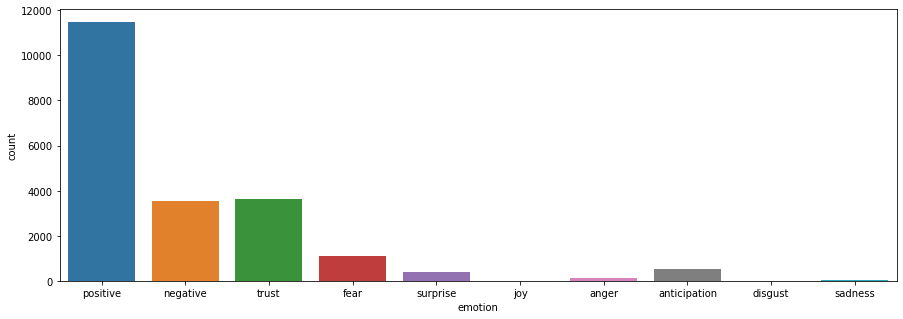

In [13]:
from nrclex import NRCLex
import sys
import seaborn as sns
import matplotlib.pyplot as plt

text_processed = loaded_dataset['text_processed']
c = 0
textlistlen = str(len(text_processed))
emotion = []
for t in text_processed:
    sys.stdout.write('\r' + str(c) + "/" + textlistlen)
    c += 1
    emotion.append(NRCLex(t).top_emotions[0][0]) 
    
loaded_dataset['emotion'] = emotion
plt.figure(figsize=(15,5))
sns.countplot(x="emotion",data=loaded_dataset )

In [14]:
import pickle
with open('dataset_processed.pkl', 'wb') as f:
    pickle.dump(loaded_dataset, f)

In [15]:
import pickle
with open('dataset_processed.pkl', 'rb') as f:
    loaded_dataset = pickle.load(f)

c:\users\abolfazl\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\abolfazl\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\abolfazl\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


20799/20800

<AxesSubplot:xlabel='heat', ylabel='count'>

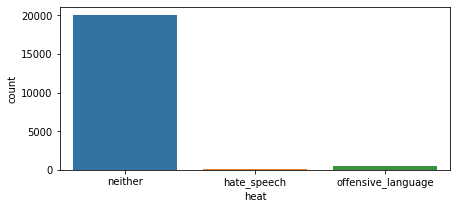

In [17]:
from hatesonar import Sonar
import sys
sonar = Sonar()

text_processed = loaded_dataset['text_processed']

c = 0
textlistlen = str(len(text_processed))
heat = []
for t in text_processed:
    sys.stdout.write('\r' + str(c) + "/" + textlistlen)
    c += 1
    sonarop = (sonar.ping(text=t))
    heat.append(sonarop['top_class']) 
    
loaded_dataset['heat'] = heat
plt.figure(figsize=(7,3))
sns.countplot(x="heat",data=loaded_dataset )

In [18]:
import pickle
with open('dataset_processed.pkl', 'wb') as f:
    pickle.dump(loaded_dataset, f)

In [1]:
import pickle
with open('dataset_processed.pkl', 'rb') as f:
    loaded_dataset = pickle.load(f)

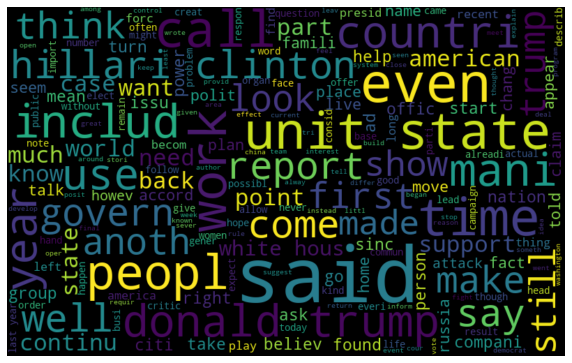

In [20]:
# visualizing which of the word is most commonly used
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# imshow-Display data as an image
# interpolation - https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html
all_words = ' '.join([text for text in loaded_dataset['text_processed'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
#random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


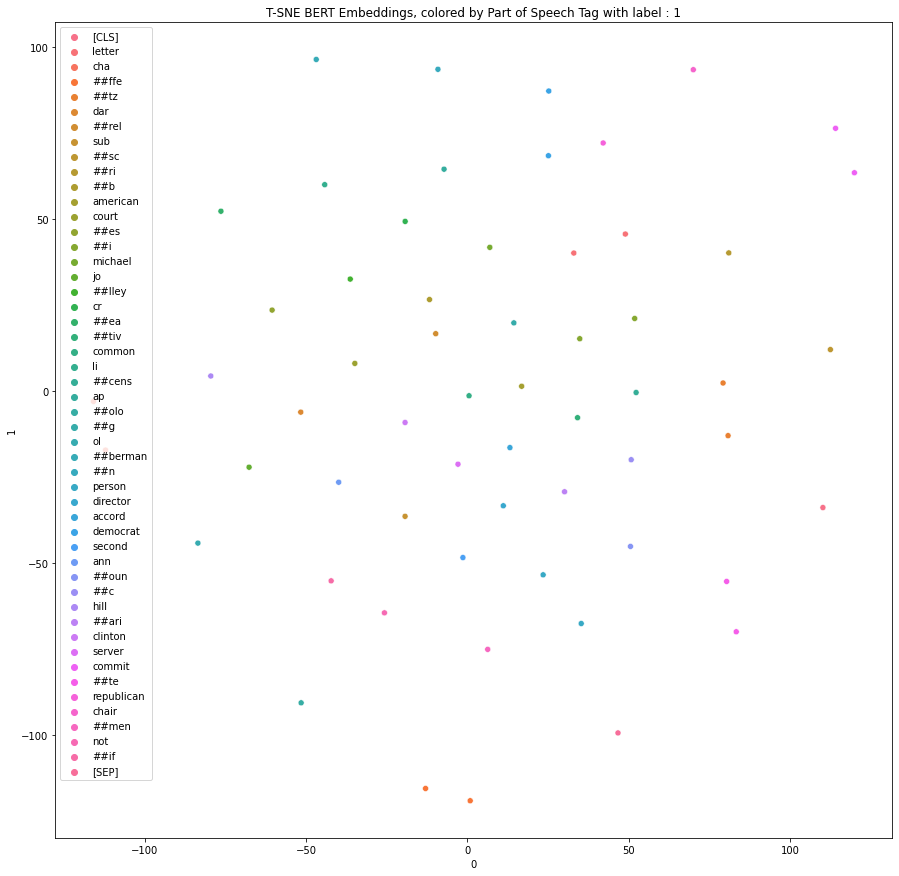

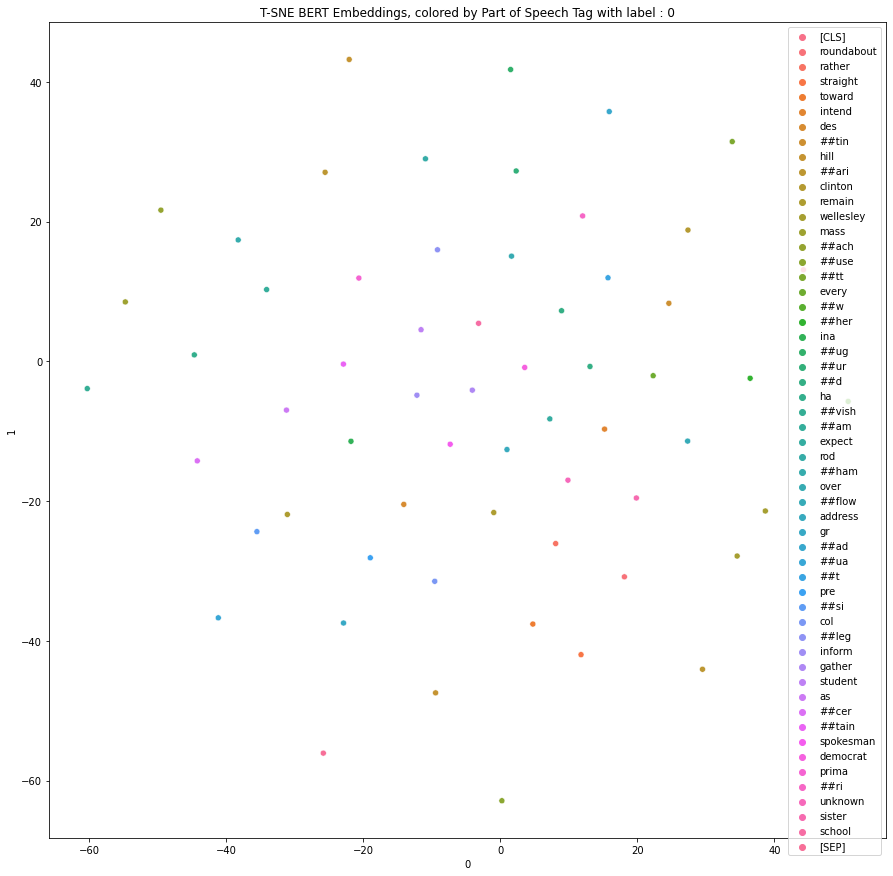

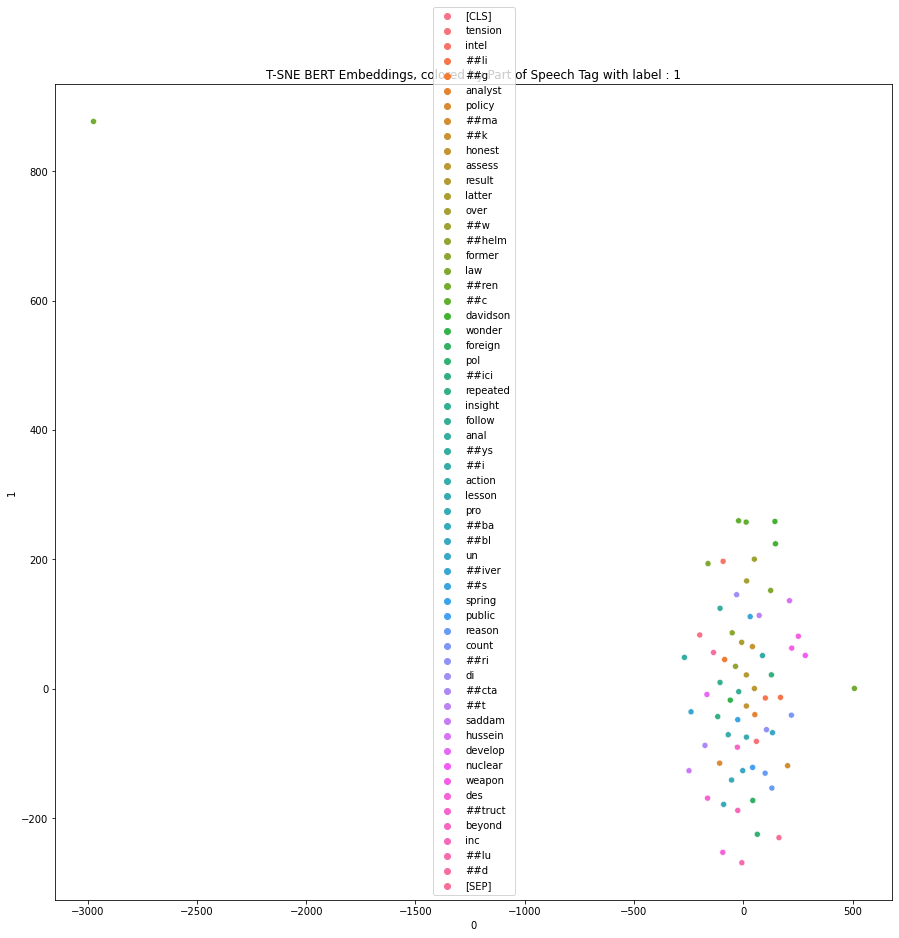

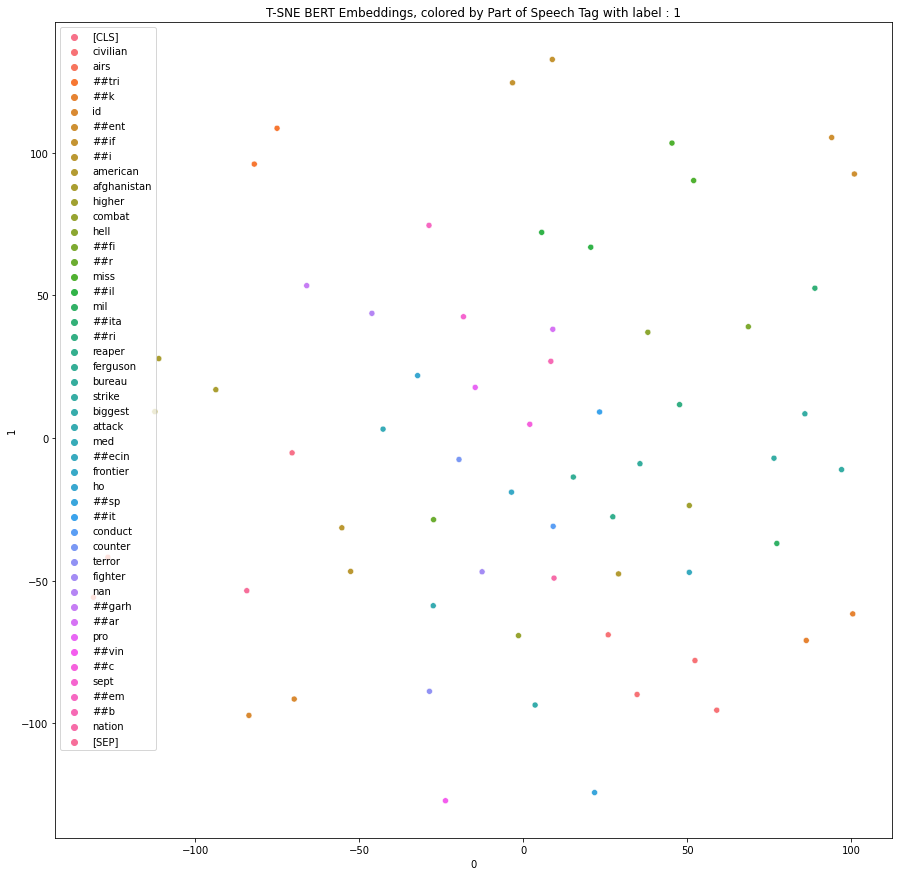

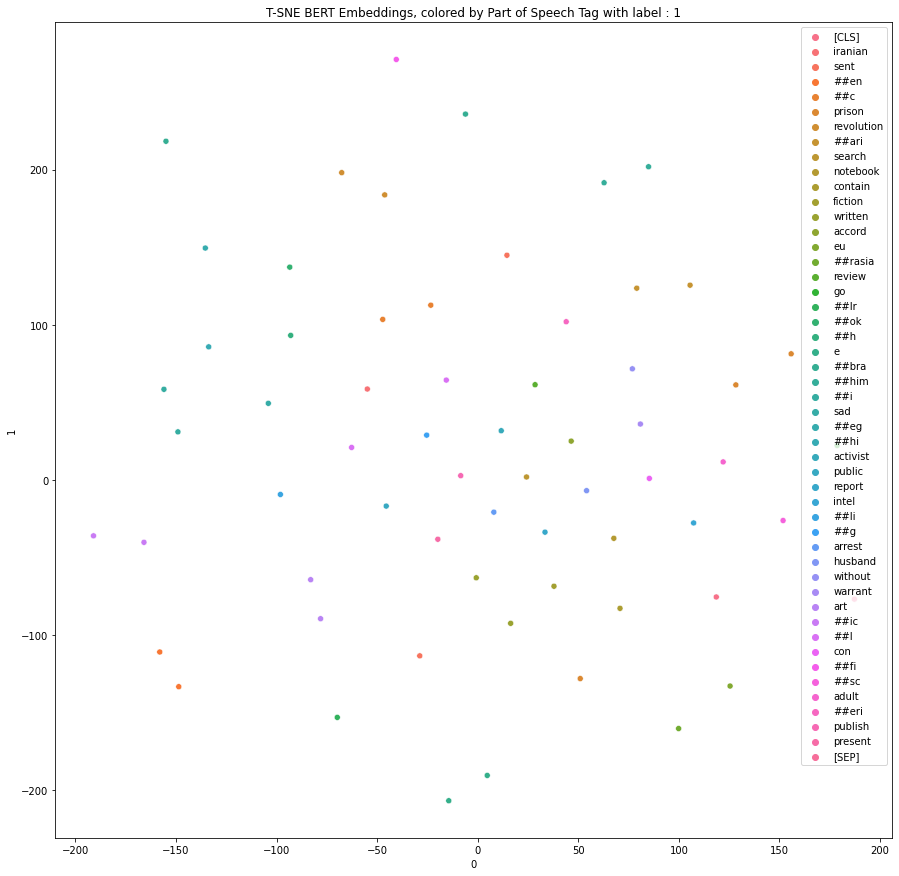

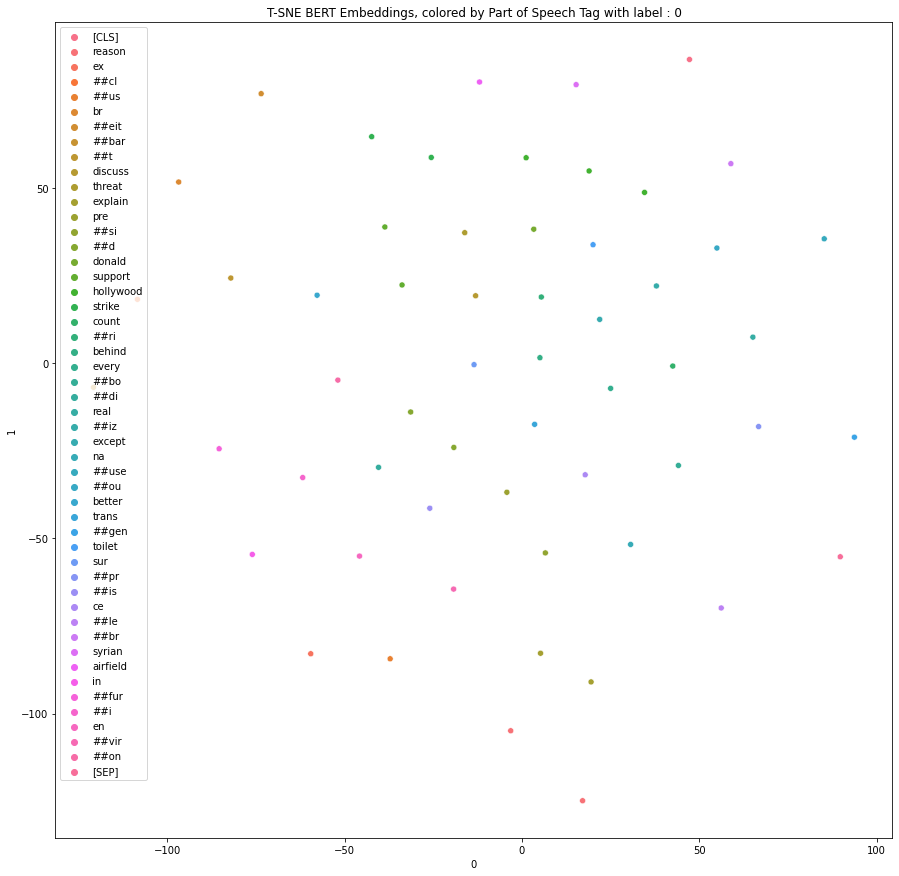

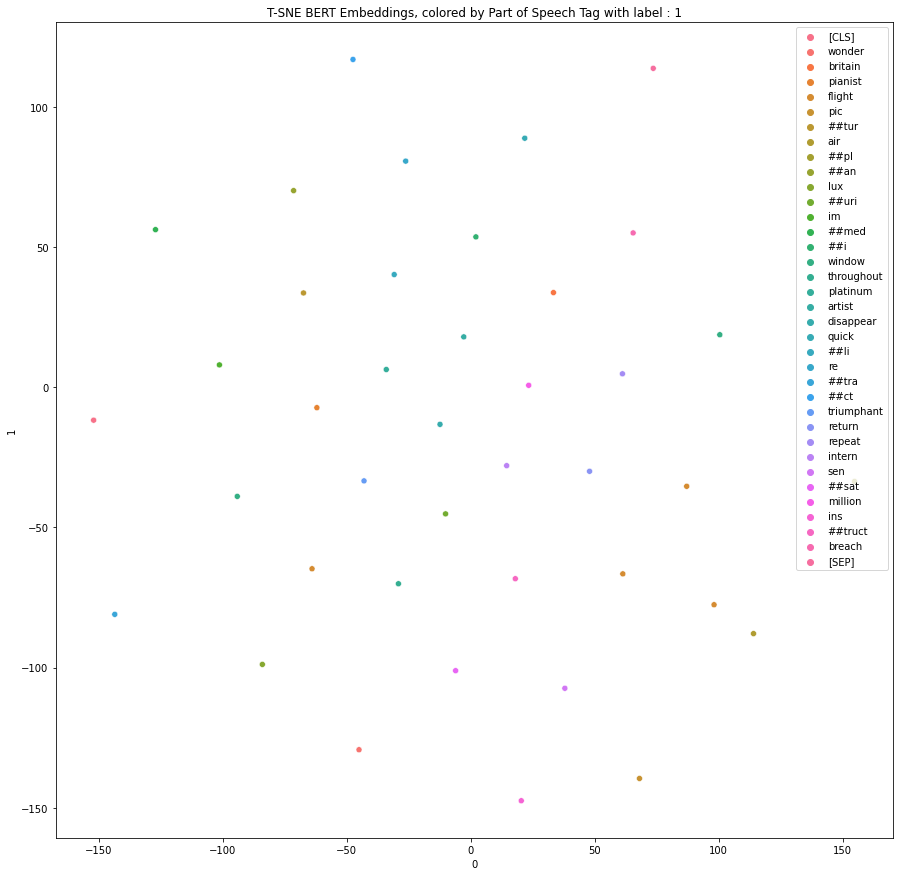

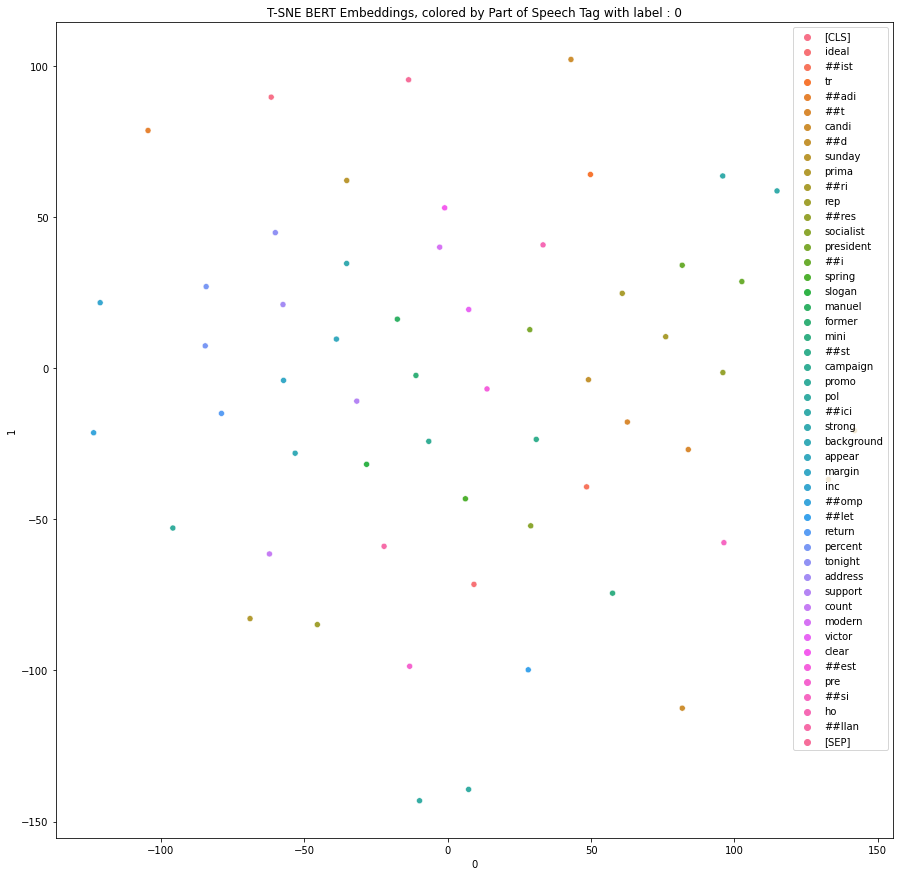

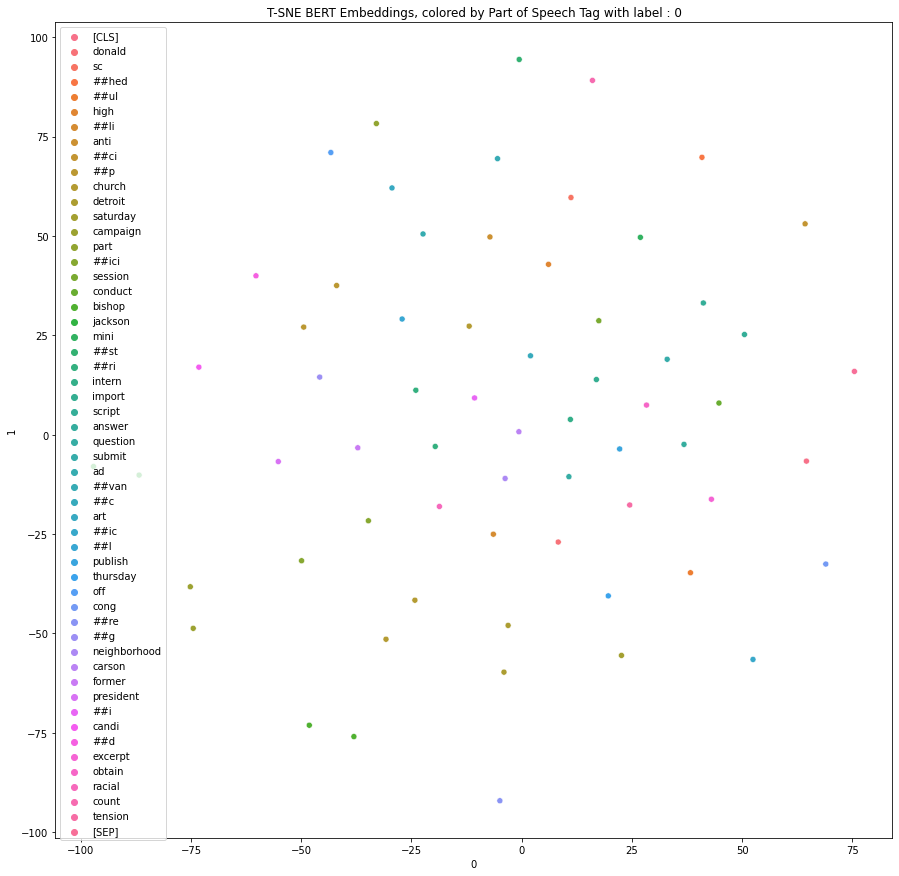

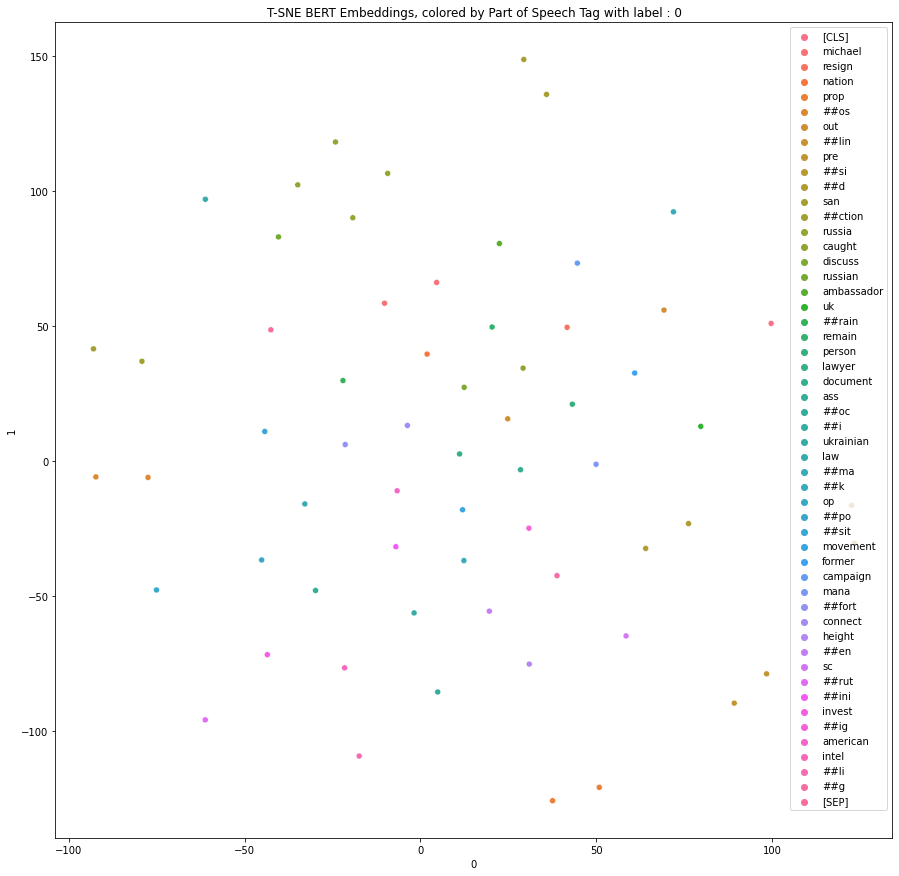

In [13]:
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import sys
import matplotlib.pyplot as plt

model = BertModel.from_pretrained('bert-base-uncased',
           output_hidden_states = True,)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def bert_text_preparation(text, tokenizer):


    marked_text = "[CLS] " + text + " [SEP]"
    
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    return tokenized_text, tokens_tensor, segments_tensors

def get_bert_embeddings(tokens_tensor, segments_tensors, model):

    # Gradient calculation id disabled
    # Model is in inference mode
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        # Removing the first hidden state
        # The first state is the input state
        hidden_states = outputs[2][1:]

    # Getting embeddings from the final BERT layer
    token_embeddings = hidden_states[-1]
    # Collapsing the tensor into 1-dimension
    token_embeddings = torch.squeeze(token_embeddings, dim=0)
    # Converting torchtensors to lists
    list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

    return list_token_embeddings


target_word_embeddings = []
loaded_dataset.text_processed = loaded_dataset.text_processed.apply(lambda i: ' '.join(filter(lambda j: len(j) > 5, i.split())))
loaded_dataset['text_processed'] = loaded_dataset['text_processed'].str.slice(0,500)
c = 0

for text in loaded_dataset['text_processed'].head(10):
    plt.figure(figsize=(15,15))
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(text, tokenizer)
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)

    mat = np.matrix([x for x in list_token_embeddings])

    from sklearn.manifold import TSNE
    model1 = TSNE(n_components=2)
    low_dim_data = model1.fit_transform(mat)
    
    #print('Lower dim data has shape',low_dim_data.shape)
    tsne_df =  pd.DataFrame(low_dim_data, tokenized_text)
    ax = sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
    ax.set_title('T-SNE BERT Embeddings, colored by Part of Speech Tag' + ' with label : ' + str(loaded_dataset['label'][c]))
    c += 1
    plt.show()
